This .ipynb investigates how does the modified kernel which obeys a 2D divergence free vector field helps improve the performance of Gaussain Model

- Noise-free environment

In [47]:
import json
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
from sklearn.model_selection import train_test_split

# read from testdata/vector_field.json
with open('testdata/vector_field.json','r') as f:
    data = json.load(f)

df = pd.DataFrame(data)


In [48]:
# split the data into training and test sets
X = df[['x1','x2']]
y = df[['y1','y2']]

shape = (df["x1"].nunique(), df["x2"].nunique())
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.99, random_state=42)


In [49]:
df.head()

,x1,x2,y1,y2
0,0.000000,0.0,-0.000000,0.0
1,0.081633,0.0,-0.081633,0.0
2,0.163265,0.0,-0.163265,0.0
3,0.244898,0.0,-0.244898,0.0
4,0.326531,0.0,-0.326531,0.0


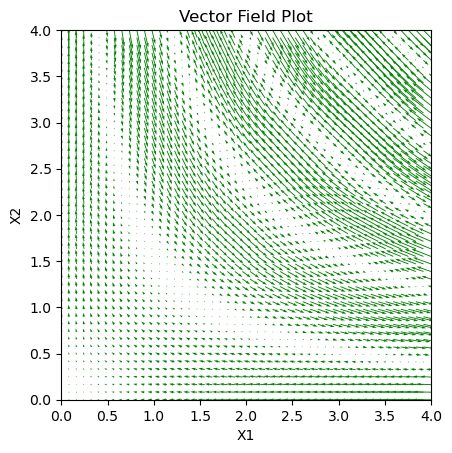

In [50]:
# Add labels and title
plt.xlabel('X1')
plt.ylabel('X2')
plt.title('Vector Field Plot')

# Set the limits of the plot
plt.xlim(0, 4)
plt.ylim(0, 4)

# plot the vector field
plt.quiver(df['x1'], df['x2'], df['y1'], df['y2'], angles='xy', scale_units='xy', scale=20, color='g')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()


In [51]:
# import jax and relevant libraries
from jax import hessian
import jax.random as jr
import jax.numpy as jnp
import gpjax as gpx
from jax import jit
from jax import config
from jaxtyping import (
    Float,
)
from gpjax.typing import (
    Array,
    ScalarFloat,
)
from beartype.typing import Union
import tensorflow_probability.substrates.jax.bijectors as tfb
from gpjax.kernels.stationary.utils import squared_distance
from gpjax.base import param_field

# 
config.update("jax_enable_x64", True)
colors = mpl.rcParams["axes.prop_cycle"].by_key()["color"]
key = jr.PRNGKey(123)
key, subkey = jr.split(key)

In [52]:
# convert data to jax arrays
X_train = jnp.array(X_train).T
y_train = jnp.array(y_train).T
X_test = jnp.array(X_test).T
y_test = jnp.array(y_test).T
X = jnp.array(X).T
y = jnp.array(y).T

In [53]:
print (y_train.shape)
print (X_train.shape)

(2, 25)
(2, 25)


In [54]:
# function to place data from csv into correct array shape
def prepare_data(df):
    pos = jnp.array([df["lon"], df["lat"]])
    vel = jnp.array([df["ubar"], df["vbar"]])
    # extract shape stored as 'metadata' in the test data
    try:
        shape = (int(df["shape"][1]), int(df["shape"][0]))  # shape = (34,16)
        return pos, vel, shape
    except KeyError:
        return pos, vel

In [55]:
print (X_train.shape)

(2, 25)


In [56]:
# Change vectors x -> X = (x,z), and vectors y -> Y = (y,z) via the artificial z label
def label_position(data):
    # introduce alternating z label
    n_points = len(data[0])
    label = jnp.tile(jnp.array([0.0, 1.0]), n_points)
    return jnp.vstack((jnp.repeat(data, repeats=2, axis=1), label)).T


# change vectors y -> Y by reshaping the velocity measurements
def stack_velocity(data):
    return data.T.flatten().reshape(-1, 1)


def dataset_3d(pos, vel):
    print ("label_position", label_position(pos).shape)
    print ("stack_velocity", stack_velocity(vel).shape)
    return gpx.Dataset(label_position(pos), stack_velocity(vel))



In [57]:
# label and place the training data into a Dataset object to be used by GPJax
dataset_train = dataset_3d(X_train,y_train)

# we also require the testing data to be relabelled for later use, such that we can query the 2Nx2N GP at the test points
dataset_ground_truth = dataset_3d(X, y)

label_position (50, 3)
stack_velocity (50, 1)
label_position (5000, 3)
stack_velocity (5000, 1)


In [58]:
from dataclasses import dataclass

@dataclass
class VelocityKernel(gpx.kernels.AbstractKernel):
    kernel0: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    kernel1: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # standard RBF-SE kernel is x and x' are on the same output, otherwise returns 0

        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)

        # achieve the correct value via 'switches' that are either 1 or 0
        k0_switch = ((z + 1) % 2) * ((zp + 1) % 2)
        k1_switch = z * zp

        return k0_switch * self.kernel0(X, Xp) + k1_switch * self.kernel1(X, Xp)

In [59]:
def initialise_gp(kernel, mean, dataset):
    prior = gpx.gps.Prior(mean_function=mean, kernel=kernel)
    likelihood = gpx.likelihoods.Gaussian(
        num_datapoints=dataset.n, obs_stddev=jnp.array([1.0e-3], dtype=jnp.float64)
    )
    posterior = prior * likelihood
    return posterior

# Define the velocity GP
mean = gpx.mean_functions.Zero()
kernel = VelocityKernel()
# kernel = gpx.kernels.RBF(active_dims=[0, 1])
velocity_posterior = initialise_gp(kernel, mean, dataset_train)

In [60]:
def optimise_mll(posterior, dataset, NIters=1000, key=key):
    # define the MLL using dataset_train
    objective = gpx.objectives.ConjugateMLL(negative=True)
    # Optimise to minimise the MLL
    opt_posterior, history = gpx.fit_scipy(
        model=posterior,
        objective=objective,
        train_data=dataset
    )
    return opt_posterior

opt_velocity_posterior = optimise_mll(velocity_posterior, dataset_train)

Initial loss is 2337.089571743689
Optimization was successful
Final loss is 96.47810974120836 after 41 iterations


In [61]:
def latent_distribution(opt_posterior, pos_3d, dataset_train):
    latent = opt_posterior.predict(pos_3d, train_data=dataset_train)
    latent_mean = latent.mean()
    latent_std = latent.stddev()
    return latent_mean, latent_std


# extract latent mean and std of g, redistribute into vectors to model F
velocity_mean, velocity_std = latent_distribution(
    opt_velocity_posterior, dataset_ground_truth.X, dataset_train
)

dataset_latent_velocity = dataset_3d(X, velocity_mean)

label_position (5000, 3)
stack_velocity (5000, 1)


In [62]:
# Residuals between ground truth and estimate

def plot_vector_field(ax, dataset, **kwargs):
    ax.quiver(
        dataset.X[::2][:, 0],
        dataset.X[::2][:, 1],
        dataset.y[::2],
        dataset.y[1::2],
        **kwargs,
    )


def prepare_ax(ax, X, Y, title, **kwargs):
    ax.set(
        xlim=[X.min() - 0.1, X.max() + 0.1],
        ylim=[Y.min() + 0.1, Y.max() + 0.1],
        aspect="equal",
        title=title,
        ylabel="latitude",
        **kwargs,
    )


def residuals(dataset_latent, dataset_ground_truth):
    return jnp.sqrt(
        (dataset_latent.y[::2] - dataset_ground_truth.y[::2]) ** 2
        + (dataset_latent.y[1::2] - dataset_ground_truth.y[1::2]) ** 2
    )


def plot_fields(
    dataset_ground_truth, dataset_trajectory, dataset_latent, shape=shape, scale=10
):
    X = dataset_ground_truth.X[:, 0][::2]
    Y = dataset_ground_truth.X[:, 1][::2]
    # make figure
    fig, ax = plt.subplots(1, 3, figsize=(12.0, 3.0), sharey=True)

    # ground truth
    plot_vector_field(
        ax[0],
        dataset_ground_truth,
        color=colors[0],
        label="Ocean Current",
        angles="xy",
        scale=scale,
    )
    plot_vector_field(
        ax[0],
        dataset_trajectory,
        color=colors[1],
        label="Drifter",
        angles="xy",
        scale=scale,
    )
    prepare_ax(ax[0], X, Y, "Ground Truth", xlabel="Longitude")

    # Latent estimate of vector field F
    plot_vector_field(ax[1], dataset_latent, color=colors[0], angles="xy", scale=scale)
    plot_vector_field(
        ax[1], dataset_trajectory, color=colors[1], angles="xy", scale=scale
    )
    prepare_ax(ax[1], X, Y, "GP Estimate", xlabel="Longitude")

    # residuals
    residuals_vel = jnp.flip(
        residuals(dataset_latent, dataset_ground_truth).reshape(shape), axis=0
    )
    im = ax[2].imshow(
        residuals_vel,
        extent=[X.min(), X.max(), Y.min(), Y.max()],
        cmap="jet",
        vmin=0,
        vmax=3,
        interpolation="spline36",
    )
    plot_vector_field(
        ax[2], dataset_trajectory, color=colors[1], angles="xy", scale=scale
    )
    prepare_ax(ax[2], X, Y, "Residuals", xlabel="Longitude")
    fig.colorbar(im, fraction=0.027, pad=0.04, orientation="vertical")

    fig.legend(
        framealpha=0.0,
        ncols=2,
        fontsize="medium",
        bbox_to_anchor=(0.5, -0.03),
        loc="lower center",
    )
    plt.show()


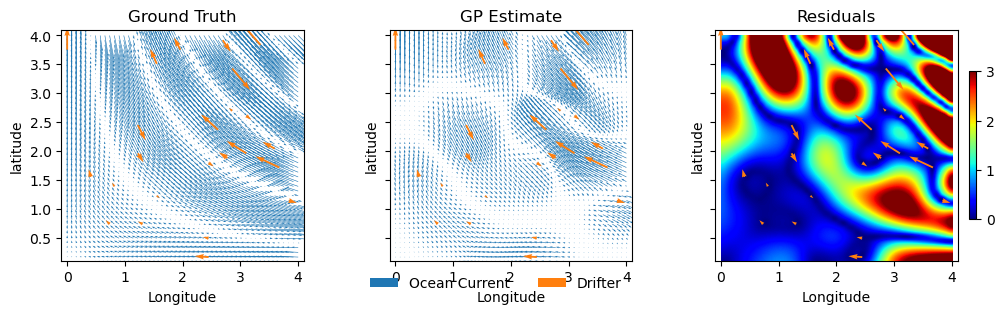

In [63]:
# plot 
plot_fields(dataset_ground_truth, dataset_train, dataset_latent_velocity, shape=shape, scale=40)


In [64]:
@dataclass
class HelmholtzKernel(gpx.kernels.AbstractKernel):
    # initialise Phi and Psi kernels as any stationary kernel in gpJax
    potential_kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    stream_kernel: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        # obtain indices for k_helm, implement in the correct sign between the derivatives
        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)
        sign = (-1) ** (z + zp)

        # convert to array to correctly index, -ve sign due to exchange symmetry (only true for stationary kernels)
        potential_dvtve = -jnp.array(
            hessian(self.potential_kernel)(X, Xp), dtype=jnp.float64
        )[z][zp]
        stream_dvtve = -jnp.array(
            hessian(self.stream_kernel)(X, Xp), dtype=jnp.float64
        )[1 - z][1 - zp]
        
        return potential_dvtve + sign * stream_dvtve

In [65]:
# Redefine Gaussian process with Helmholtz kernel
kernel = HelmholtzKernel()
helmholtz_posterior = initialise_gp(kernel, mean, dataset_train)
# Optimise hyperparameters using BFGS
opt_helmholtz_posterior = optimise_mll(helmholtz_posterior, dataset_train)

Initial loss is 342.2148806130086
Optimization was successful
Final loss is 79.45668043453523 after 35 iterations


In [66]:
# obtain latent distribution, extract x and y values over g
helmholtz_mean, helmholtz_std = latent_distribution(
    opt_helmholtz_posterior, dataset_ground_truth.X, dataset_train
)
dataset_latent_helmholtz = dataset_3d(X, helmholtz_mean)


label_position (5000, 3)
stack_velocity (5000, 1)


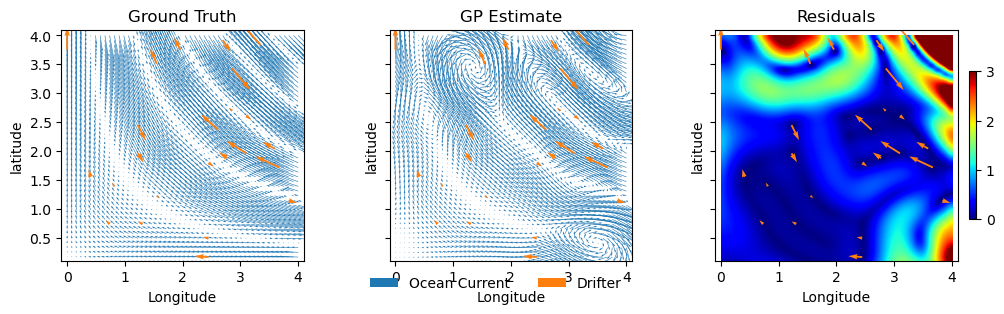

In [67]:

plot_fields(dataset_ground_truth, dataset_train, dataset_latent_helmholtz, scale = 40)

In [68]:
@dataclass
class DivergencefreeKernel(gpx.kernels.AbstractKernel):
    kernel0: gpx.kernels.AbstractKernel = gpx.kernels.RBF(active_dims=[0, 1])
    lengthscale: Union[ScalarFloat, Float[Array, " D"]] = param_field(
        jnp.array(1.0), bijector=tfb.Softplus()
    )
    variance: ScalarFloat = param_field(jnp.array(1.0), bijector=tfb.Softplus())
    name: str = "DivergencefreeKernel"

    def __call__(
        self, X: Float[Array, "1 D"], Xp: Float[Array, "1 D"]
    ) -> Float[Array, "1"]:
        
        z = jnp.array(X[2], dtype=int)
        zp = jnp.array(Xp[2], dtype=int)

        Updated_kernel = -jnp.array(
            hessian(self.kernel0)(X, Xp) * ((X[2] == Xp[2]) * 2 -1), dtype=jnp.float64
        )[1-z][1-zp]
        
        return Updated_kernel

Initial loss is 1815.1352317372007
Optimization was successful
Final loss is 79.45667721274187 after 54 iterations
label_position (5000, 3)
stack_velocity (5000, 1)


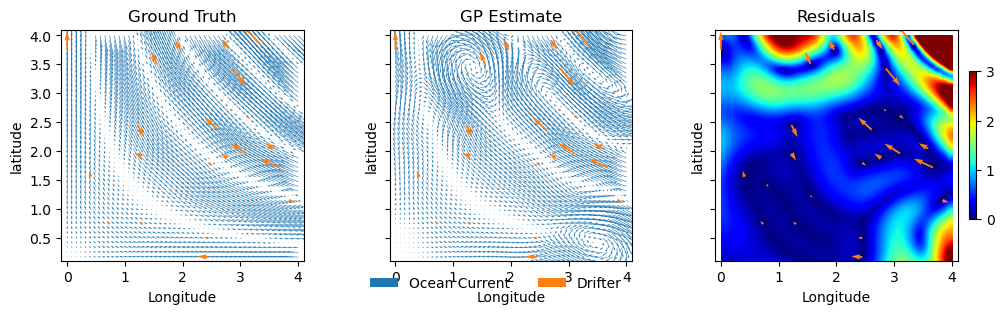

In [69]:
# Redefine Gaussian process with divergencefree kernel
kernel = DivergencefreeKernel()
divergencefree_posterior = initialise_gp(kernel, mean, dataset_train)
# Optimise hyperparameters using BFGS
opt_divergencefree_posterior = optimise_mll(divergencefree_posterior, dataset_train)

# obtain latent distribution, extract x and y values over g
divergencefree_mean, divergencefree_std = latent_distribution(
    opt_divergencefree_posterior, dataset_ground_truth.X, dataset_train
)
dataset_latent_divergencefree = dataset_3d(X, divergencefree_mean)

plot_fields(dataset_ground_truth, dataset_train, dataset_latent_divergencefree, scale = 50)

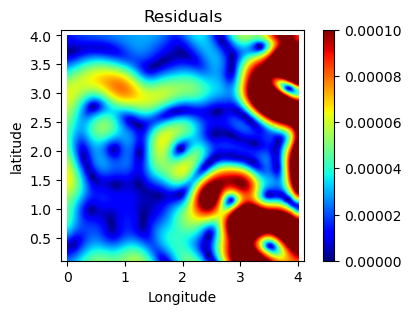

In [70]:
# calculate the residuals between the two models
helmholtz_divergencefree_diff = jnp.flip(
        residuals(dataset_latent_divergencefree, dataset_latent_helmholtz).reshape(shape), axis=0
    )

fig, ax = plt.subplots(1, 1, figsize=(6.0, 3.0), sharey=True)

X_axis = dataset_ground_truth.X[:, 0][::2]
Y_axis = dataset_ground_truth.X[:, 1][::2]

im = ax.imshow(
        helmholtz_divergencefree_diff ,
        extent=[X_axis.min(), X_axis.max(), Y_axis.min(), Y_axis.max()],
        cmap="jet",
        vmin=0,
        vmax=0.0001,
        interpolation="spline36",
    )
# plot_vector_field(
#     ax, dataset_trajectory, color=colors[1], angles="xy", scale=scale
# )
prepare_ax(ax, X_axis, Y_axis, "Residuals", xlabel="Longitude")
fig.colorbar(im, fraction=0.027, pad=0.04, orientation="vertical")

fig.legend(
    framealpha=0.0,
    ncols=2,
    fontsize="medium",
    bbox_to_anchor=(0.5, -0.03),
    loc="lower center",
)
plt.show()
